# Выберите топ-гипотезу из предыдущего задания и подробно опишите, как будет проходить А/Б-тест

Процесс A-B тестирования подразумевает следующий порядок:

## Формулировка гипотезы

| N | Гипотеза | Источник | Почему не стоит проверять | Личный рейтинг | Почему такая оценка |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| 1 | Если уменьшить стоимость при высоком спросе на 5%, то общая прибыль будет выше изначальной более чем на 5%, из за увеличения конверсий в оформление заказа после более комфортной увиденной цены  | Данные + Предположение | Риск потерять деньги | 8 | Требует либо дополнительных данных, либо тестирования, поскольку сказать однозначно невозможно |

## Планирование теста

### Размер выборки
Для начала мы определяем размер требуемой выборки, используя [Калькулятор](https://www.evanmiller.org/ab-testing/)

In [112]:
import pandas as pd
df = pd.read_csv('../H1/new_dataframe.csv')

In [113]:
# Creating a dataset fo our task
df_pto = df.loc[df.price_seen == 1].groupby('surge')[['order_made', 'ride_completed', 'user_cancelled']].mean().copy()
df_pto[['seen_count']] = df.groupby('surge')[['price_seen']].sum()
df_pto[['order_count']] = df.groupby('surge')[['order_made']].sum()
print(df_pto)

# Conversion_rate calculation
df_pto['conversion_rate'] = df_pto.ride_completed / df_pto.order_made
print('\nКонверсия в деньги из заказа в Surge = {:.1f}%'.format(df_pto.loc['surge','conversion_rate'] * 100))
print('Конверсия в деньги из заказа не в Surge = {:.1f}%'.format(df_pto.loc['no surge','conversion_rate'] * 100))
print('Поскольку данные цифры не сильно отличаются, мы не будем включать это в расчет требуемого нового уровня конверсий')

# Minimum detectable effect calculation
new_surge_conversion = (((1 - (df_pto.order_count['no surge']/ df_pto.order_count.sum())) * 1.05) /
                        (df_pto.seen_count.surge / df_pto.order_count.sum()))
print('\nТребуемая конверсия для повышения прибыли при высоком спросе на 5% = {:.1f}%'.format(new_surge_conversion * 100))
print('Минимальная разница между данными конверсиями должна быть = {:.1f}%'.format((new_surge_conversion - df_pto.order_made.surge) * 100))
print('\nСтатистическая сила будет равна 80%, а уровень значимости 5%')

          order_made  ride_completed  user_cancelled  seen_count  order_count
surge                                                                        
no surge    0.859085        0.729427        0.129658       59788        51363
surge       0.722845        0.611699        0.111146       31643        22873

Конверсия в деньги из заказа в Surge = 84.6%
Конверсия в деньги из заказа не в Surge = 84.9%
Поскольку данные цифры не сильно отличаются, мы не будем включать это в расчет требуемого нового уровня конверсий

Требуемая конверсия для повышения прибыли при высоком спросе на 5% = 75.9%
Минимальная разница между данными конверсиями должна быть = 3.6%

Статистическая сила будет равна 80%, а уровень значимости 5%


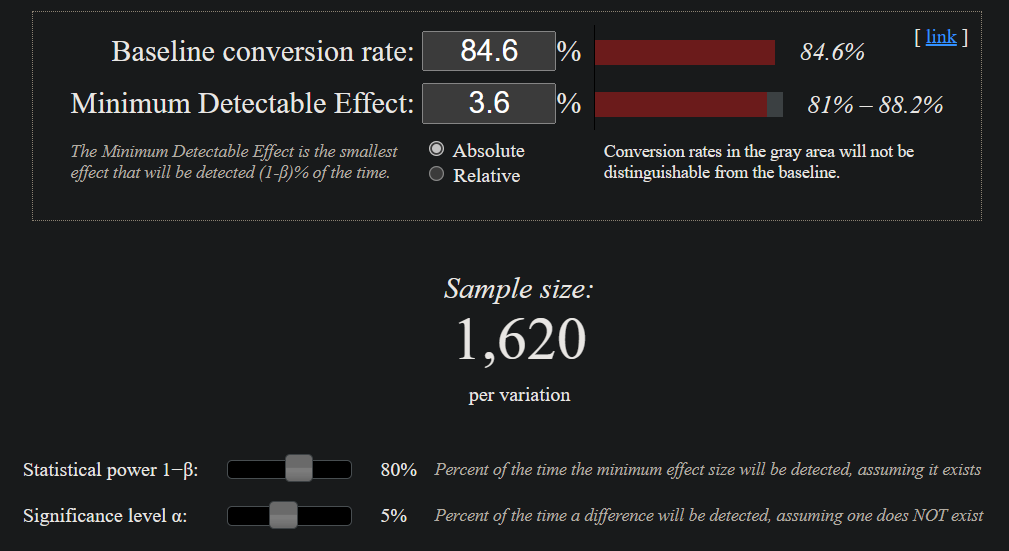

### Процедура A/B теста:

- Сперва мы возьмем группу случайных людей из Surge объемом более 3240 человек
- После этого разделим её на две
- Проверим на неоднородность по интересующим нас метрикам

`Далее происходит описание самого процесса, который реализовать не предоставляется возможным физически`
- Одна часть останется неизменной. Другая получит описанное выше изменение. Будут замеряться основные и побочные показатели
- Будет проведено сравнение с целью получить проверить являются ли наши изменения статистически значимыми

## Подготовка выборки

Сразу подчеркну, что желательно взять больше людей, ведь не все зайдут, увидят изменение и.т.д. Здесь взял именно 1700 просто для того чтобы соответствовало скриншоту выше

In [114]:
import numpy as np

df_user = df.groupby(['user_id', 'os']).mean(numeric_only=True).reset_index().drop(columns=['user_id','os']).copy()
df_user['rand'] = df_user.apply(lambda row: np.random.rand(), axis=1)

df_usergroup1 = df_user.loc[df_user['rand'] > 0.5].reset_index().drop(columns=['rand', 'index'], index=range(1700,len(df_user)), errors='ignore')
df_usergroup2 = df_user.loc[df_user['rand'] <= 0.5].reset_index().drop(columns=['rand', 'index'], index=range(1700,len(df_user)), errors='ignore')
print('Группа 1 имеет размер =', len(df_usergroup1), '\nГруппа 2 имеет размер =', len(df_usergroup2))

Группа 1 имеет размер = 1700 
Группа 2 имеет размер = 1700


In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from tqdm.auto import tqdm
alpha = 0.05

In [116]:
# Данную функцию я пока использую из материалов наших по статистике, не вникнув до конца как ИМЕННО она работает
# Но она работает, потому не парюсь. Напишу впоследствии свою функцию, поскольку хочу понять в деталях
def get_bootstrap(
    data_column_1,                    # Числовые значения первой выборки
    data_column_2,                    # Числовые значения второй выборки
    boot_it = 500,                   # Количество бутстрэп-подвыборок
    statistic = np.mean,              # Интересующая нас статистика
    bootstrap_conf_level = 1-alpha    # Уровень значимости
):
    
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):    # Извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True            # Параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len,                 # Чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    print('p-value: %.8f' % p_value)

    return p_value

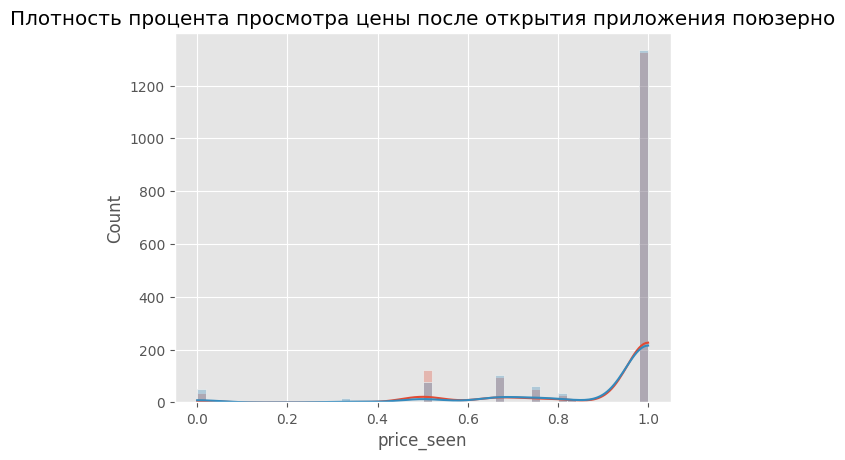

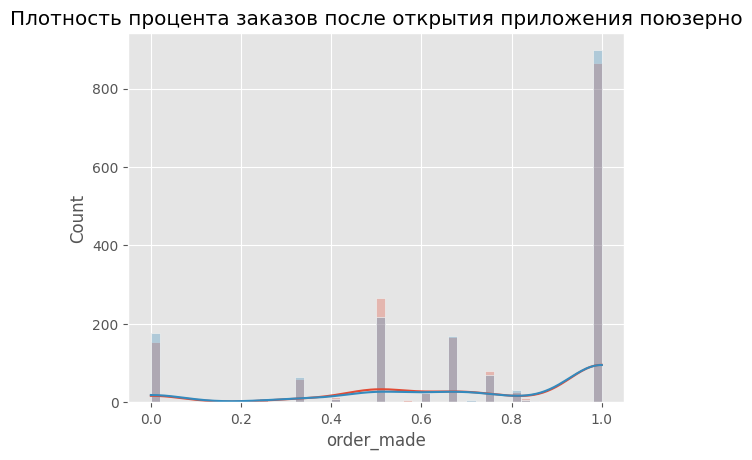

In [117]:
sns.histplot(df_usergroup1.price_seen, bins=50, kde=True, alpha=0.3)
sns.histplot(df_usergroup2.price_seen, bins=50, kde=True, alpha=0.3)
plt.title('Плотность процента просмотра цены после открытия приложения поюзерно')
plt.show()

sns.histplot(df_usergroup1.order_made, bins=50, kde=True, alpha=0.3)
sns.histplot(df_usergroup2.order_made, bins=50, kde=True, alpha=0.3)
plt.title('Плотность процента заказов после открытия приложения поюзерно')
plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

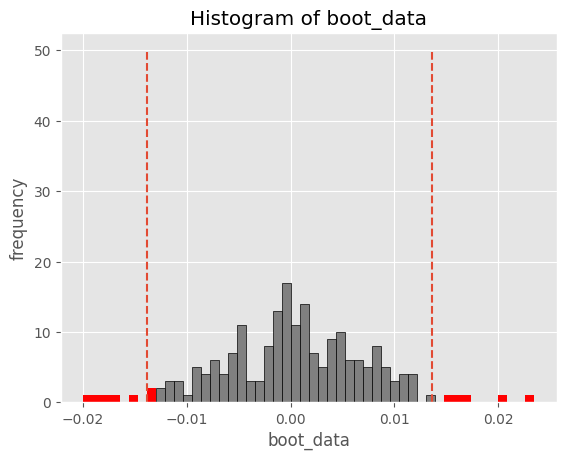

p-value: 0.96356788
Не отвергаем нулевую гипотезу


  0%|          | 0/200 [00:00<?, ?it/s]

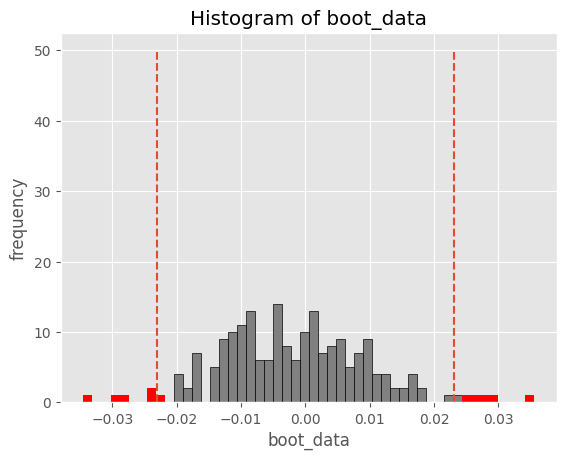

p-value: 0.87759155
Не отвергаем нулевую гипотезу


In [118]:
tmp_boot1 = get_bootstrap(
    df_usergroup1.price_seen,                 # числовые значения первой выборки
    df_usergroup2.price_seen,                 # числовые значения второй выборки
    boot_it = 200,                 # количество бутстрэп-подвыборок
    statistic = np.mean,            # интересующая нас статистика
    bootstrap_conf_level = 1-alpha  # уровень значимости
)

if (tmp_boot1 < alpha/2):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

tmp_boot2 = get_bootstrap(
    df_usergroup1.order_made,                 # числовые значения первой выборки
    df_usergroup2.order_made,                 # числовые значения второй выборки
    boot_it = 200,                 # количество бутстрэп-подвыборок
    statistic = np.mean,            # интересующая нас статистика
    bootstrap_conf_level = 1-alpha  # уровень значимости
)

if (tmp_boot2 < alpha/2):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

Итак, у нас есть 2 выборки по 1700 чел. с подходящими показателями. Их можно экспортировать в csv или иной формат данных и отправить в систему

## Запуск теста и Анализ результатов

К сожалению данный момент я не способен произвести. Но опишу как это будет происходить
- Мы берем интересующее нас изменение и делаем 2 (в нашем случае) версии. Например в таргетированной рекламе меняем текст
- Каждую версию. мы показываем нашей выборке, замеряя интересующий показатель и показатели, на которые данное изменение может поменять негативно. В нашем случае это может быть средний чек, например, расстояние проеханное или еще что-то
- Далее прогоняем через какой-либо тест, чтобы увидеть результат (я сейчас работаю над бутстрапом, поскольку мне слишком нравится перспектива возможности применения где угодно, но ничего не мешает использовать иные инструменты). Например мы в таргетированной рекламе по данным группам пускаем наши рекламнвые кампании.
- Если p-value меньше α, в таком случае отвергаем нулевую гипотезу, у нас все получилось или стало сильно хуже. Отклонение есть, вопрос только в какую сторону. В случае, если же нет, то принимаем решение на основании остальных данных